## Slice Thickness and Profile on TO2 in Head Coil

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib as mpl

from mriqa.dcmio import fetch_series

The TO2 phantom has two crossed plates and two pairs of wedges. Here we use the two crossed plates to estimate the full-width half maximum of the slice profile for 5mm and 3mm slices as described in the IPEM *green book*.

To go from the width of the profile in the image we need to scale by the tangent of the plate angle which here we take to be 11.7 degrees.

To facilitate the analysis we interpolate the images to higher resolution first. Having extracted the thick profiles we fit a quadratic bias the the start and end of the profile assuming this is outside of the plate and is just the gain field for the background liquid in the phantom. We divide the profiles by this modelled gain variation and also invert them to give a positive going *line shape*.

This is fitted using cubic splines and the half height position found to determine the FWHM which is then scaled appropriately for pixel size and plate projection.

Although we correct for it below, it is better to use prescan normalised images to limit the bias in the background field.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from mriqa.phantoms import find_phantom, TO2

from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom
from scipy.interpolate import UnivariateSpline
from scipy.stats.mstats import gmean

from itertools import islice

def report_slice_profiles(dobj, frame=None, coil_name='Head'):
    '''Takes a DICOM object which is a single slice of phantom TO2 where the plate profiles
       are reasonably central. Plots the image with the profile positions marked on, the raw profile
       and a normalised profile accounting for a multiplicative bias field. The FWHM is reported in mm
       for each profile individually and for their geometric mean.
    '''
    # Get image data an interpolate up for analysis, noting change of pixel size
    image = dobj.pixel_array & 0xfff

    # Handle multiframes
    if 'NumberofFrames' in dobj and dobj.NumberofFrames > 1:
        if frame is None:
            frame = dobj.NumberofFrames//2
        image = image[frame]
        pixel_spacing = dobj.PerframeFunctionalGroups[0].PixelMeasures[0].PixelSpacing
        slice_thickness = dobj.PerframeFunctionalGroups[0].PixelMeasures[0].SliceThickness
    else:
        pixel_spacing = dobj.PixelSpacing
        slice_thickness = dobj.SliceThickness

    interpolation_factor = 2
    image = rescale_intensity(zoom(image, interpolation_factor))
    pix_dims = np.asarray(pixel_spacing) / interpolation_factor
    assert np.allclose(pix_dims[0], pix_dims[1])
    
    # Centre phantom
    expected_radius = TO2['Diameter'] / 2 / pix_dims[0]
    centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)
    
    # Positions of plates
    plates = TO2['Features']['Plates']

    # Plotting area
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.subplots_adjust(wspace=0.5)

    # Phantom image
    axes[0].imshow(image, cmap='bone')
    axes[0].axis('off')
    axes[0].axis('image')

    # Thick profile through first inclined plate
    (x, y), (dx, dy) = np.array(plates[0]) / pix_dims
    x += centre_x
    y += centre_y
    profile_1 = np.mean(image[y:y+dy, x:x+dx], axis=1)
    
    # a list of colours from the line colour cycle so we can match these in the image overlays
    # TODO: this uses a private API which may change
    line_colours = list(islice(axes[0]._get_lines.color_cycle, 0, 2))
    
    # Show profiles on phantom
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color=line_colours[0], alpha=0.25))

    # Thick profile through second inclined plate
    (x, y), (dx, dy) = np.array(plates[1]) / pix_dims
    x += centre_x
    y += centre_y
    profile_2 = np.mean(image[y:y+dy, x:x+dx], axis=1)

    # Show on phantom
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color=line_colours[1], alpha=0.25))

    axes[0].set_title(r'Series %d, Image %d' % (dobj.SeriesNumber, dobj.InstanceNumber))

    # Plot raw profiles
    axes[1].plot(profile_1, label='1')
    axes[1].plot(profile_2, label='2')
    axes[1].set_xlabel('Pixel Position')
    axes[1].set_ylabel('Image Brightness (Raw)')
    axes[1].set_title('Head Coil (%1.0f mm)' % slice_thickness)
    axes[1].legend()
    axes[1].grid(True)

    # Invert profile and normalise to quadratic baseline fitted to the ends of the profile
    x = range(20) + range(len(profile_1)-20, len(profile_1))
    baseline_1 = np.poly1d(np.polyfit(x, profile_1[x], 2))(range(len(profile_1)))
    profile_1 /= baseline_1

    x = range(20) + range(len(profile_2)-20, len(profile_2))
    baseline_2 = np.poly1d(np.polyfit(x, profile_2[x], 2))(range(len(profile_2)))
    profile_2 /= baseline_2

    profile_1 = 1 - profile_1
    profile_2 = 1 - profile_2

    # Plot the normalised profile
    axes[2].plot(profile_1, label='1')
    axes[2].plot(profile_2, label='2')
    axes[2].set_xlabel('Pixel Position')
    axes[2].set_ylabel('Image Brightness (Normalised to Baseline)')
    axes[2].set_title('%s Coil (%1.0f mm)' % (coil_name, slice_thickness))
    axes[2].legend()
    axes[2].grid(True)

    # Create a spline of the profile shifted to move its half-height to zero 
    spline = UnivariateSpline(range(len(profile_1)), profile_1-np.max(profile_1)/2, s=0)
    r1, r2 = spline.roots() # find the roots
    axes[2].axvspan(r1, r2, facecolor=line_colours[0], alpha=0.25)
    
    fwhm_1_pixels = (r2-r1)

    spline = UnivariateSpline(range(len(profile_2)), profile_2-np.max(profile_2)/2, s=0)
    r1, r2 = spline.roots()
    axes[2].axvspan(r1, r2, facecolor=line_colours[1], alpha=0.25)
    fwhm_2_pixels = (r2-r1)

    plt.show()

    # Calculate FWHM in mm taking account of pixel rescaling and plate projection angle 
    xspacing, yspacing = pix_dims
    plate_angle = 11.7 # degrees

    fwhm_gm_pixels = gmean([fwhm_1_pixels, fwhm_2_pixels])

    fwhm_1_mm = fwhm_1_pixels * yspacing * np.tan(np.radians(plate_angle))
    fwhm_2_mm = fwhm_2_pixels * yspacing * np.tan(np.radians(plate_angle))
    
    fwhm_gm_mm = gmean([fwhm_1_mm, fwhm_2_mm])
    
    print('FWHM     (1) = ', round(fwhm_1_pixels, 1),  'pixels, or', round(fwhm_1_mm, 1),  'mm')
    print('FWHM     (2) = ', round(fwhm_2_pixels, 1),  'pixels, or', round(fwhm_2_mm, 1),  'mm')
    print('FWHM (GMEAN) = ', round(fwhm_gm_pixels, 1), 'pixels, or', round(fwhm_gm_mm, 1), 'mm')
    return

### Slice Profile for 5mm slice

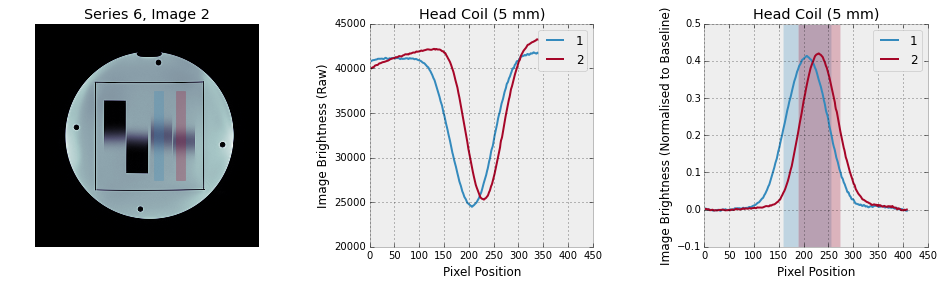

FWHM     (1) =  97.6 pixels, or 4.9 mm
FWHM     (2) =  84.9 pixels, or 4.3 mm
FWHM (GMEAN) =  91.0 pixels, or 4.6 mm


In [5]:
# 5mm
patid = 'PQA20150331RHD'
stuid = '1'
# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
sernos = [6]
imgno  = 2 # single frame
dobjs = fetch_series(patid, stuid, sernos, 'CRIC')
with mpl.style.context('bmh'):
    report_slice_profiles(dobjs[imgno - 1])

### Slice Profile for 3mm slice

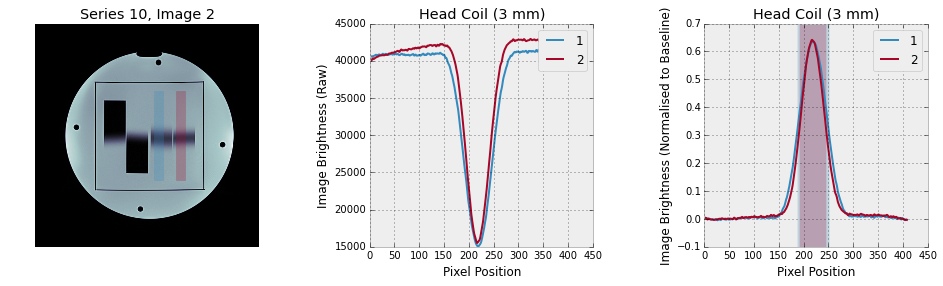

FWHM     (1) =  63.0 pixels, or 3.2 mm
FWHM     (2) =  53.8 pixels, or 2.7 mm
FWHM (GMEAN) =  58.2 pixels, or 2.9 mm


In [7]:
# 3mm
patid = 'PQA20150331RHD'
stuid = '1'
sernos = [10]
imgno  = 2 # single frame
dobjs = fetch_series(patid, stuid, sernos, 'CRIC')
with mpl.style.context('bmh'):
    report_slice_profiles(dobjs[imgno - 1])